Fraud Data shape: (151112, 11)
Credit Card Data shape: (283726, 31)
IP-country mapping shape: (138846, 3)

--- Class imbalance in fraud dataset ---


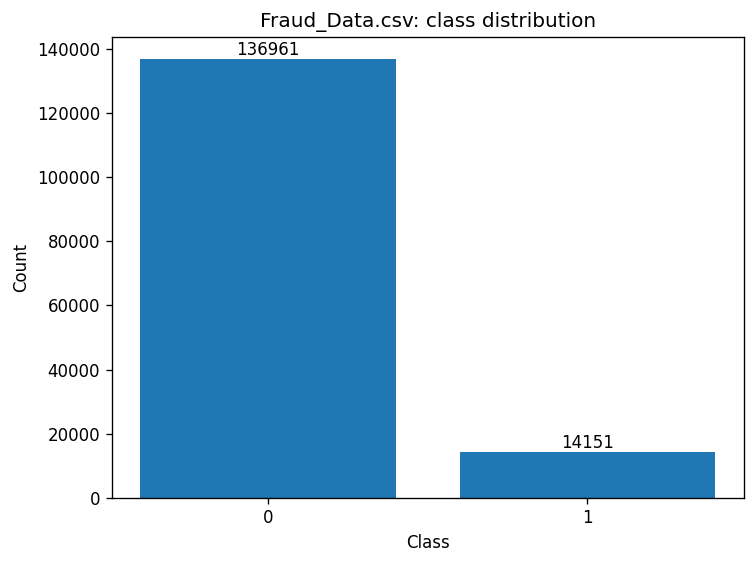


Missing values (fraud_df):
user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
dtype: int64


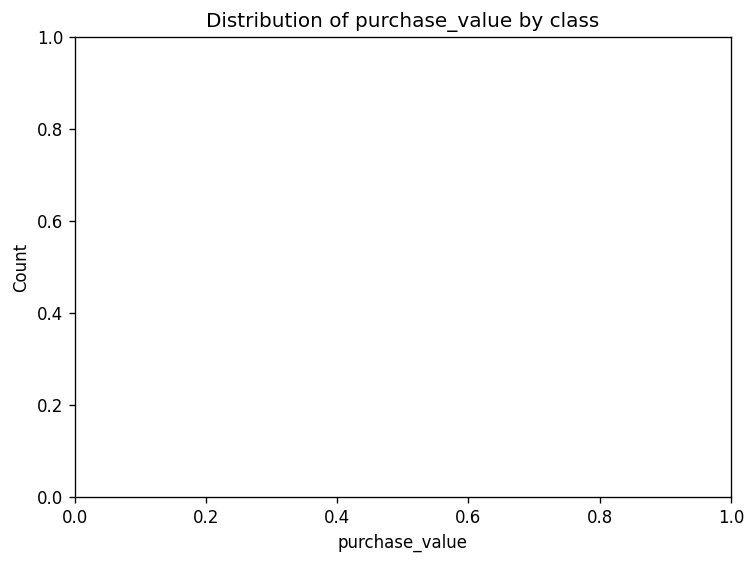

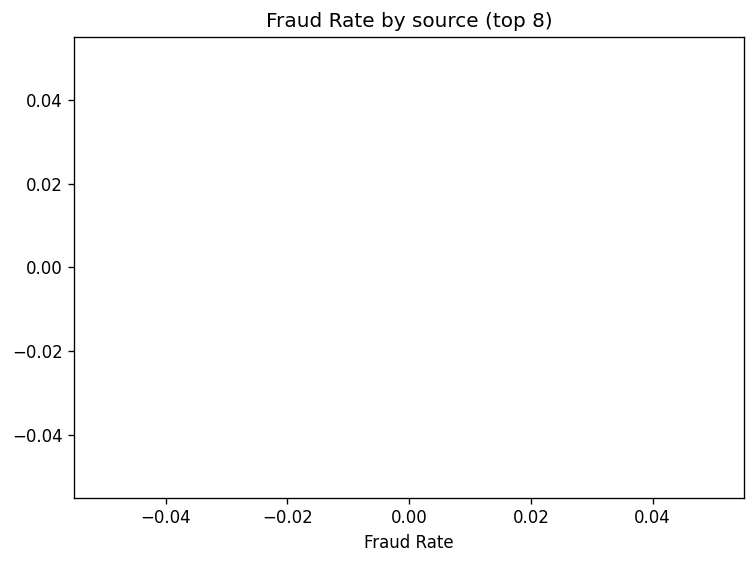

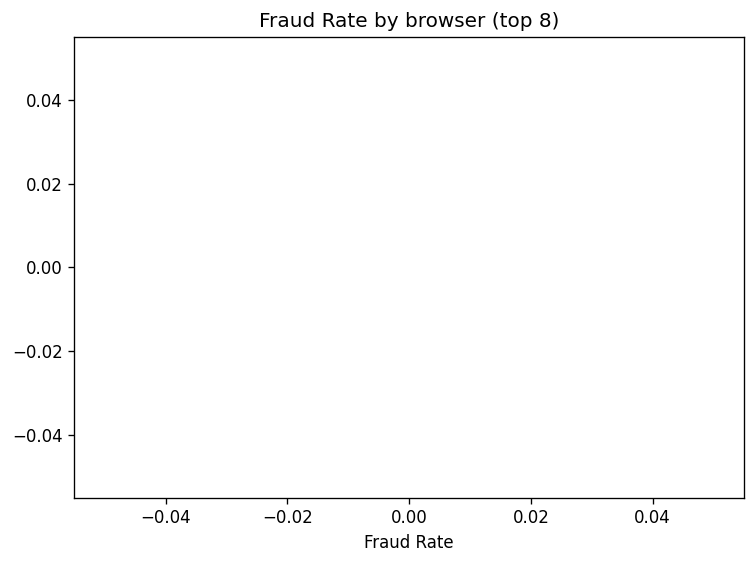

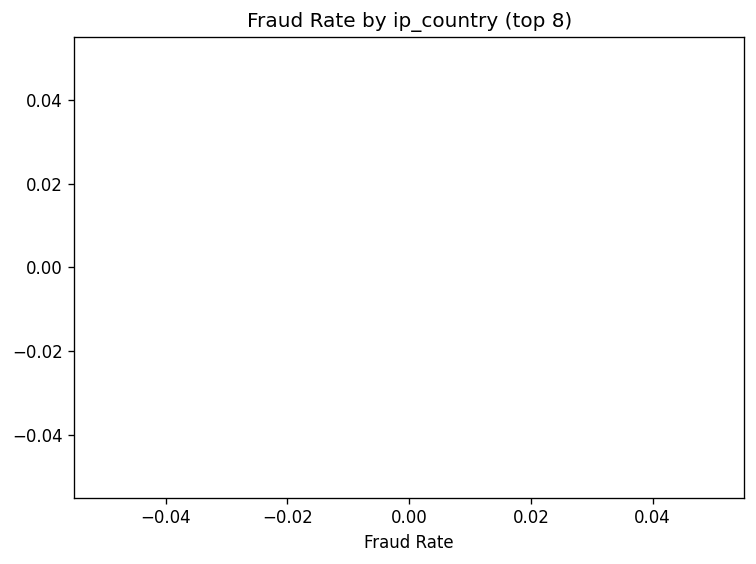

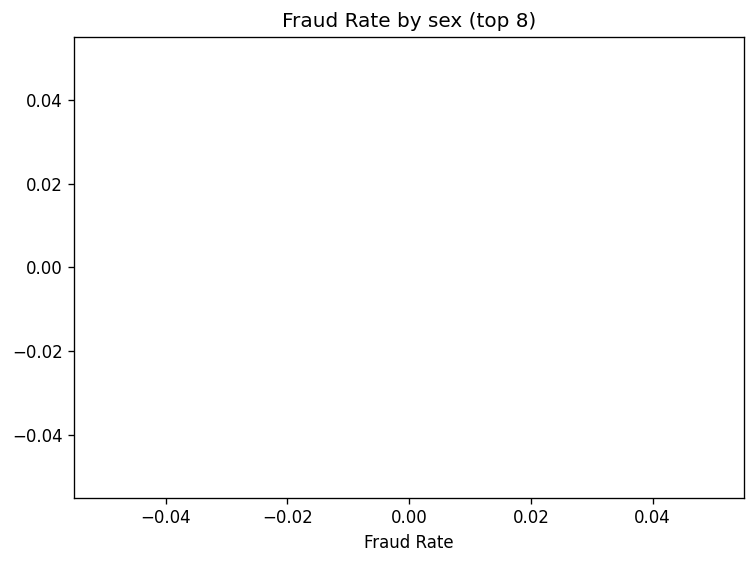

C:\Users\h_user\AppData\Local\Temp\ipykernel_24988\2000827527.py:182: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(pivot, aspect='auto', origin='lower')


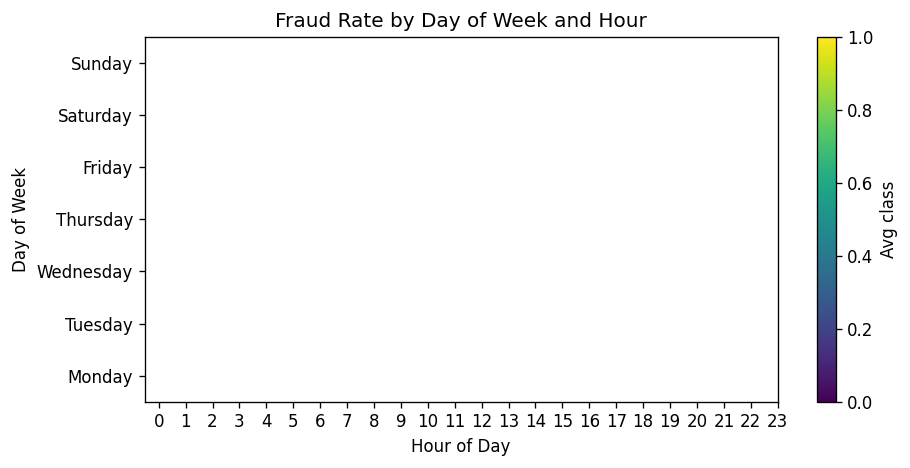

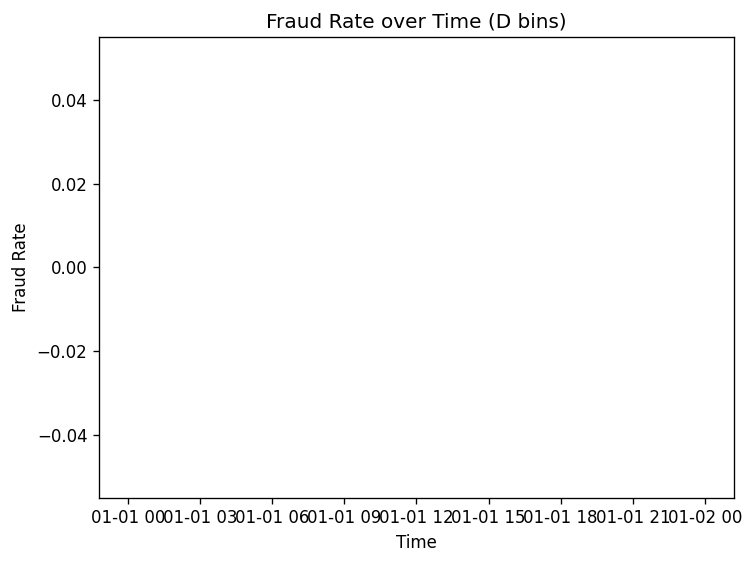


--- Class imbalance in credit card dataset ---


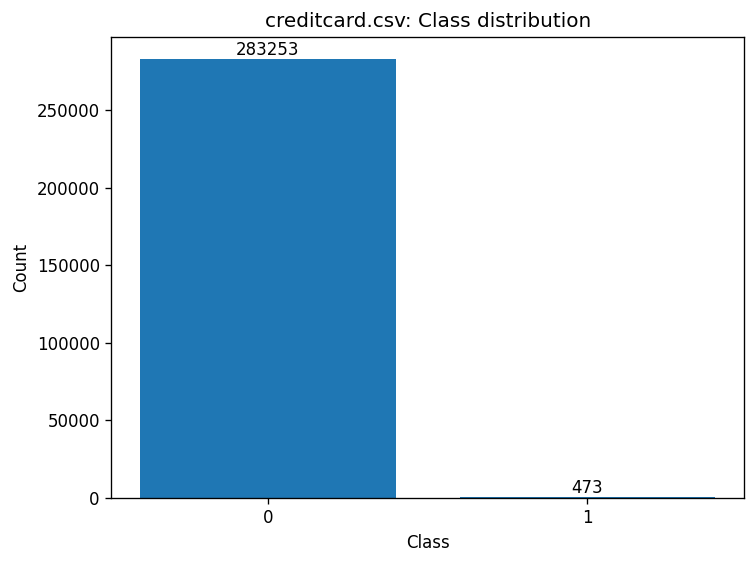

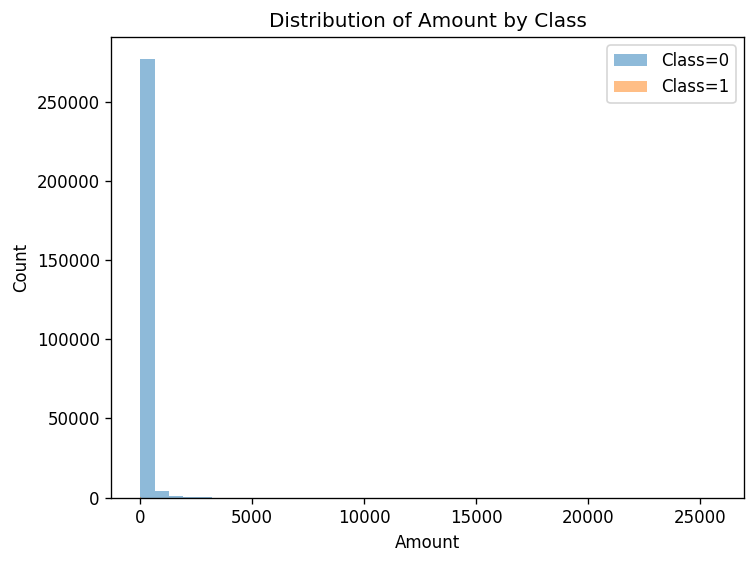


Top features correlated with fraud in creditcard.csv:
V17    0.313498
V14    0.293375
V12    0.250711
V10    0.206971
V16    0.187186
V3     0.182322
V7     0.172347
V11    0.149067
V4     0.129326
V18    0.105340
Name: Class, dtype: float64

=== Summary for target=class ===
Overall count: 0
Positive (fraud) count: 0
Negative count: 0
Fraud rate: nan

=== Summary for target=Class ===
Overall count: 283726
Positive (fraud) count: 473
Negative count: 283253
Fraud rate: 0.0017


In [6]:
# === Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipaddress
import pyarrow.parquet
from pandas.io.parquet import to_parquet
from datetime import timedelta
from collections import Counter

# For consistent plotting
plt.rcParams['figure.dpi'] = 120

# === Utility / Base Classes ===

class DataLoader:
    """Load and perform initial cleaning on required datasets."""
    def __init__(self, fraud_path, ip_path, credit_path):
        self.fraud_path = fraud_path
        self.ip_path = ip_path
        self.credit_path = credit_path

    def load_fraud(self):
        df = pd.read_csv(self.fraud_path)
        # Timestamp parsing
        df['signup_time'] = pd.to_datetime(df['signup_time'], errors='coerce')
        df['purchase_time'] = pd.to_datetime(df['purchase_time'], errors='coerce')
        # Drop exact duplicates
        df = df.drop_duplicates().reset_index(drop=True)
        return df

    def load_ip_country(self):
        ip_df = pd.read_csv(self.ip_path)
        # Convert the bounds to integers for range matching
        ip_df['lower_int'] = ip_df['lower_bound_ip_address'].astype(int)
        ip_df['upper_int'] = ip_df['upper_bound_ip_address'].astype(int)
        # Keep needed columns
        return ip_df[['lower_int', 'upper_int', 'country']].sort_values('lower_int').reset_index(drop=True)

    def load_credit(self):
        df = pd.read_csv(self.credit_path)
        # No timestamp conversion needed (Time is seconds since first transaction)
        df = df.drop_duplicates().reset_index(drop=True)
        return df

class FeatureEngineer:
    """Construct derived features for fraud data."""

    @staticmethod
    def ip_to_int(ip_str):
        # Use ipaddress library for robust conversion; assume IPv4 dotted decimal
        try:
            return int(ipaddress.ip_address(ip_str))
        except Exception:
            return np.nan

    def add_ip_country(self, fraud_df, ip_df):
        # Convert ip_address to integer representation
        fraud_df['ip_int'] = fraud_df['ip_address'].apply(self.ip_to_int)
        # Drop rows where ip conversion failed
        fraud_df = fraud_df.dropna(subset=['ip_int']).copy()
        fraud_df['ip_int'] = fraud_df['ip_int'].astype(int)

        # We'll do a range join: for each fraud row, find the ip_df row where lower_int <= ip_int <= upper_int
        # Efficient approach: sort and use merge_asof then filter
        ip_sorted = ip_df.sort_values('lower_int').reset_index(drop=True)
        fraud_sorted = fraud_df.sort_values('ip_int').reset_index(drop=True)

        merged = pd.merge_asof(
            fraud_sorted,
            ip_sorted,
            left_on='ip_int',
            right_on='lower_int',
            direction='backward',
            suffixes=('','_ip')
        )
        # Filter to ensure ip_int <= upper_int (since merge_asof only guarantees lower_int <= ip_int)
        merged = merged[merged['ip_int'] <= merged['upper_int']].copy()
        # If some IPs didn't match, country will be NaN
        merged.rename(columns={'country': 'ip_country'}, inplace=True)
        return merged

    @staticmethod
    def add_time_features(fraud_df):
        # Hour of day and day of week
        fraud_df['hour_of_day'] = fraud_df['purchase_time'].dt.hour
        fraud_df['day_of_week'] = fraud_df['purchase_time'].dt.day_name()
        # Time since signup in seconds / minutes / hours
        fraud_df['time_since_signup'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).dt.total_seconds()
        # Replace negative or missing with NaN
        fraud_df.loc[fraud_df['time_since_signup'] < 0, 'time_since_signup'] = np.nan
        return fraud_df

    @staticmethod
    def add_user_velocity(fraud_df):
        # Count previous purchases per user up to current purchase time
        fraud_df = fraud_df.sort_values(['user_id', 'purchase_time'])
        fraud_df['user_txn_count_so_far'] = fraud_df.groupby('user_id').cumcount()
        # Time since last purchase
        fraud_df['last_purchase_time'] = fraud_df.groupby('user_id')['purchase_time'].shift(1)
        fraud_df['time_since_last_purchase'] = (fraud_df['purchase_time'] - fraud_df['last_purchase_time']).dt.total_seconds()
        fraud_df['time_since_last_purchase'] = fraud_df['time_since_last_purchase'].fillna(-1)
        # -1 indicates first purchase
        return fraud_df

# === EDA / Visualization Helpers ===

class EDA:
    """Exploratory Data Analysis for both datasets."""

    def __init__(self):
        pass

    @staticmethod
    def plot_class_balance(series, title="Class Distribution"):
        counts = series.value_counts().sort_index()
        labels = counts.index.astype(str)
        plt.figure()
        plt.bar(labels, counts.values)
        plt.title(title)
        plt.xlabel("Class")
        plt.ylabel("Count")
        for i, v in enumerate(counts.values):
            plt.text(i, v + max(counts.values)*0.01, str(v), ha='center')
        plt.tight_layout()
        plt.show()

    @staticmethod
    @staticmethod
    def plot_numeric_distribution(df, column, by_class='class', bins=50):
        plt.figure()
        has_label = False
        for cls in sorted(df[by_class].dropna().unique()):
            subset = df[df[by_class] == cls]
            if subset.empty:
                continue
            plt.hist(subset[column].dropna(), bins=bins, alpha=0.5, label=f"{by_class}={cls}", density=False)
            has_label = True
        plt.title(f"Distribution of {column} by {by_class}")
        plt.xlabel(column)
        plt.ylabel("Count")
        if has_label:
            plt.legend()
        plt.tight_layout()
        plt.show()


    @staticmethod
    def bar_categorical_rate(df, cat_col, target_col, top_n=10):
        # Show fraud rate per category (only for top_n frequent categories)
        counts = df[cat_col].value_counts().nlargest(top_n)
        rates = []
        for cat in counts.index:
            subset = df[df[cat_col] == cat]
            rate = subset[target_col].mean()
            rates.append(rate)
        plt.figure()
        plt.barh([str(c) for c in counts.index][::-1], rates[::-1])
        plt.title(f"Fraud Rate by {cat_col} (top {top_n})")
        plt.xlabel("Fraud Rate")
        plt.tight_layout()
        plt.show()

    @staticmethod
    def time_series_fraud_rate(df, time_col='purchase_time', freq='D', target='class'):
        ts = df.set_index(time_col).resample(freq)[target].mean()
        plt.figure()
        plt.plot(ts.index, ts.values, marker='o')
        plt.title(f"Fraud Rate over Time ({freq} bins)")
        plt.xlabel("Time")
        plt.ylabel("Fraud Rate")
        plt.tight_layout()
        plt.show()

    @staticmethod
    def heatmap_hour_day(df, target='class'):
        pivot = df.pivot_table(index='day_of_week', columns='hour_of_day', values=target, aggfunc='mean')
        # Reorder days for readability
        order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
        pivot = pivot.reindex(order)
        plt.figure(figsize=(8,4))
        plt.imshow(pivot, aspect='auto', origin='lower')
        plt.colorbar(label=f"Avg {target}")
        plt.title(f"Fraud Rate by Day of Week and Hour")
        plt.xlabel("Hour of Day")
        plt.ylabel("Day of Week")
        plt.xticks(ticks=range(0,24), labels=range(0,24))
        plt.yticks(ticks=range(len(order)), labels=order)
        plt.tight_layout()
        plt.show()

# === Execution: Load, preprocess, and run EDA ===

# Paths - replace with actual file paths if different
fraud_csv = "../data/Fraud_Data.csv"              # e-commerce
ip_csv = "../data/IpAddress_to_Country.csv"
credit_csv = "../data/creditcard.csv"              # bank credit transactions

# Instantiate loaders and engineers
loader = DataLoader(fraud_csv, ip_csv, credit_csv)
fe = FeatureEngineer()
eda = EDA()

# Load datasets
fraud_df = loader.load_fraud()
ip_df = loader.load_ip_country()
credit_df = loader.load_credit()

# Basic overview
print("Fraud Data shape:", fraud_df.shape)
print("Credit Card Data shape:", credit_df.shape)
print("IP-country mapping shape:", ip_df.shape)

# === EDA on Fraud_Data.csv ===
print("\n--- Class imbalance in fraud dataset ---")
# The target column is named 'class' in fraud_df
eda.plot_class_balance(fraud_df['class'], title="Fraud_Data.csv: class distribution")

# Feature engineering: geolocation, time, velocity
fraud_df = fe.add_ip_country(fraud_df, ip_df)
fraud_df = fe.add_time_features(fraud_df)
fraud_df = fe.add_user_velocity(fraud_df)

# Inspect missing after merges
print("\nMissing values (fraud_df):")
print(fraud_df.isnull().sum().sort_values(ascending=False).head(10))

# Visualizations
# Numeric: purchase_value
eda.plot_numeric_distribution(fraud_df, 'purchase_value', by_class='class', bins=40)

# Categorical fraud rate: source, browser, ip_country, sex
for cat in ['source', 'browser', 'ip_country', 'sex']:
    if cat in fraud_df.columns:
        eda.bar_categorical_rate(fraud_df, cat, 'class', top_n=8)

# Time patterns
eda.heatmap_hour_day(fraud_df, target='class')
eda.time_series_fraud_rate(fraud_df, time_col='purchase_time', freq='D', target='class')

# === EDA on creditcard.csv ===
print("\n--- Class imbalance in credit card dataset ---")
# Target is 'Class' (capitalized)
eda.plot_class_balance(credit_df['Class'], title="creditcard.csv: Class distribution")

# Quick distribution of Amount by class
eda.plot_numeric_distribution(credit_df, 'Amount', by_class='Class', bins=40)

# Since credit dataset uses anonymized components (V1..V28), we can inspect correlations for top features:
corr = credit_df.corr()
# Example: show top correlations with Class
corr_with_class = corr['Class'].abs().sort_values(ascending=False).drop('Class')
print("\nTop features correlated with fraud in creditcard.csv:")
print(corr_with_class.head(10))

# === Summary Statistics ===
def print_basic_stats(df, target_col):
    print(f"\n=== Summary for target={target_col} ===")
    print("Overall count:", len(df))
    print("Positive (fraud) count:", df[target_col].sum())
    print("Negative count:", len(df) - df[target_col].sum())
    print("Fraud rate: {:.4f}".format(df[target_col].mean()))

print_basic_stats(fraud_df, 'class')
print_basic_stats(credit_df, 'Class')

# === Save cleaned intermediate EDA snapshots if desired ===
fraud_df.to_parquet("../data/processed_fraud_data.parquet", index=False)
credit_df.to_parquet("../data/processed_credit_data.parquet", index=False)

fraud_df.to_csv("../data/processed_fraud_data.parquet", index=False)
credit_df.to_csv("../data/processed_credit_data.parquet", index=False)
